# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [2]:
# libraries for numerical analysis, data manipulation and plotting
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# libraries for image
import cv2
from google.colab.patches import cv2_imshow

# libraries for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# libraries for DeepLearning and CNN
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, SpatialDropout2D, Activation, Input
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# warning
import warnings
warnings.filterwarnings('ignore')

## Setting seeds

In [4]:
random_state = 42
# reset session
def reset_session():
  clear_session()
  tf.compat.v1.reset_default_graph()
  # reset seeds
  random.seed(random_state)
  np.random.seed(random_state)
  tf.random.set_seed(random_state)

reset_session()

## Loading the dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
label_path = "/content/drive/MyDrive/AI_ML_PGP/Projects/PlantSeedlingsClassification/Labels.csv"
img_path = "/content/drive/MyDrive/AI_ML_PGP/Projects/PlantSeedlingsClassification/images.npy"

In [7]:
X = np.load(img_path)
y = pd.read_csv(label_path)

## Data Overview

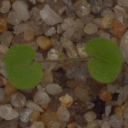

In [8]:
# checking the data is loaded and displaying the first image
cv2_imshow(X[0])

In [9]:
# checking the data is loaded for the label
y.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


### Understand the shape of the dataset

In [10]:
X.shape, y.shape

((4750, 128, 128, 3), (4750, 1))

In [11]:
X.min(), X.max()

(0, 255)

In [12]:
y.nunique()

,0
Label,12


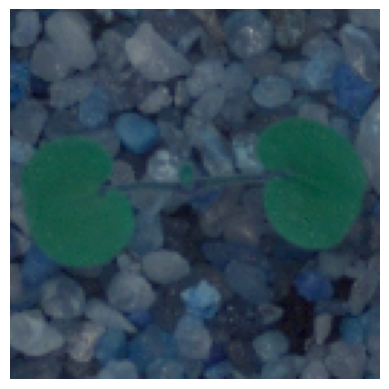

In [13]:
# checking the channels of the image
plt.imshow(X[0])
plt.axis('off')
plt.show()

### Observations
* Images are stored in 4 dimensional numpy array
* The first dimension refers to the number of images and we have total 4750 images
* The second dimension refers to the number of pixels on the x-axis and the third dimension refers to the number of pixels on the y-axis. We have image size of 128*128 pixels.
* the 4th dimension refers to number of channels in the dataset and we have 3 channels.
* We observed that there are 12 unqiue labels in the given dataset.
* We displayed the image using `cv2` library and also ploted the image using `matplotlib`. We noticed when we plot the image, the image appears to be blue tinted. However, when we display the same image using `cv2`, it looks normal. This proves that the images are in BGR format instead of RGB. BGR is the default format for `cv2`, hence, it renders the images normal.

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [14]:
# Unique labels
num_classes = 12
categories = np.unique(y)
print('Unique Categories:',categories)

Unique Categories: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']


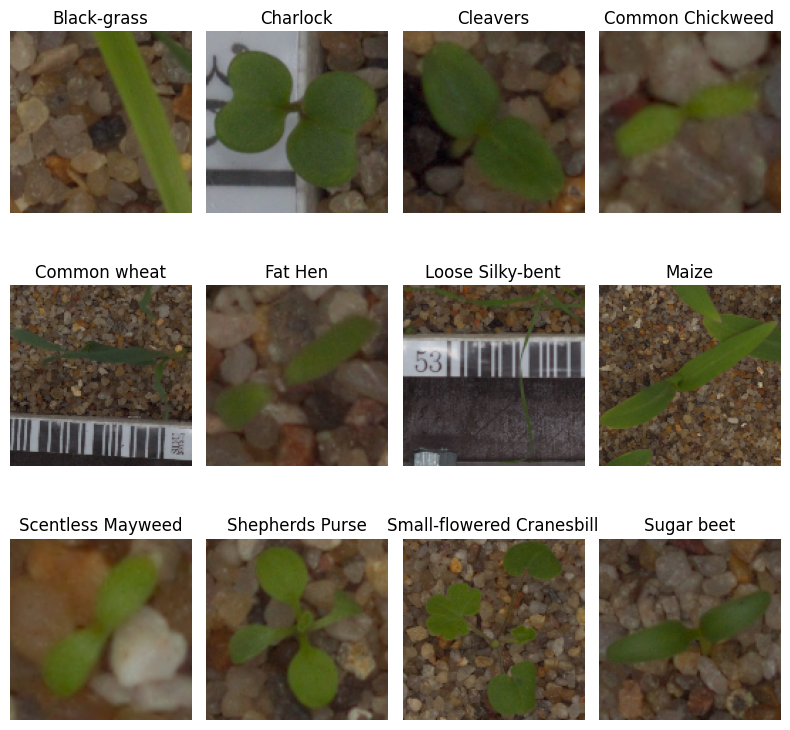

In [15]:
# Print random image from each categories
fig, axes = plt.subplots(3, 4, figsize = (8, 8))
for cat, ax in zip(categories, axes.flatten()):
  random.seed(random_state)
  rand_of_each_cat = random.choice(y[y['Label'] == cat].index)
  img = cv2.cvtColor(X[rand_of_each_cat], cv2.COLOR_BGR2RGB)
  ax.imshow(img)
  ax.set_title(cat)
  ax.axis('off')
plt.tight_layout()
plt.show()

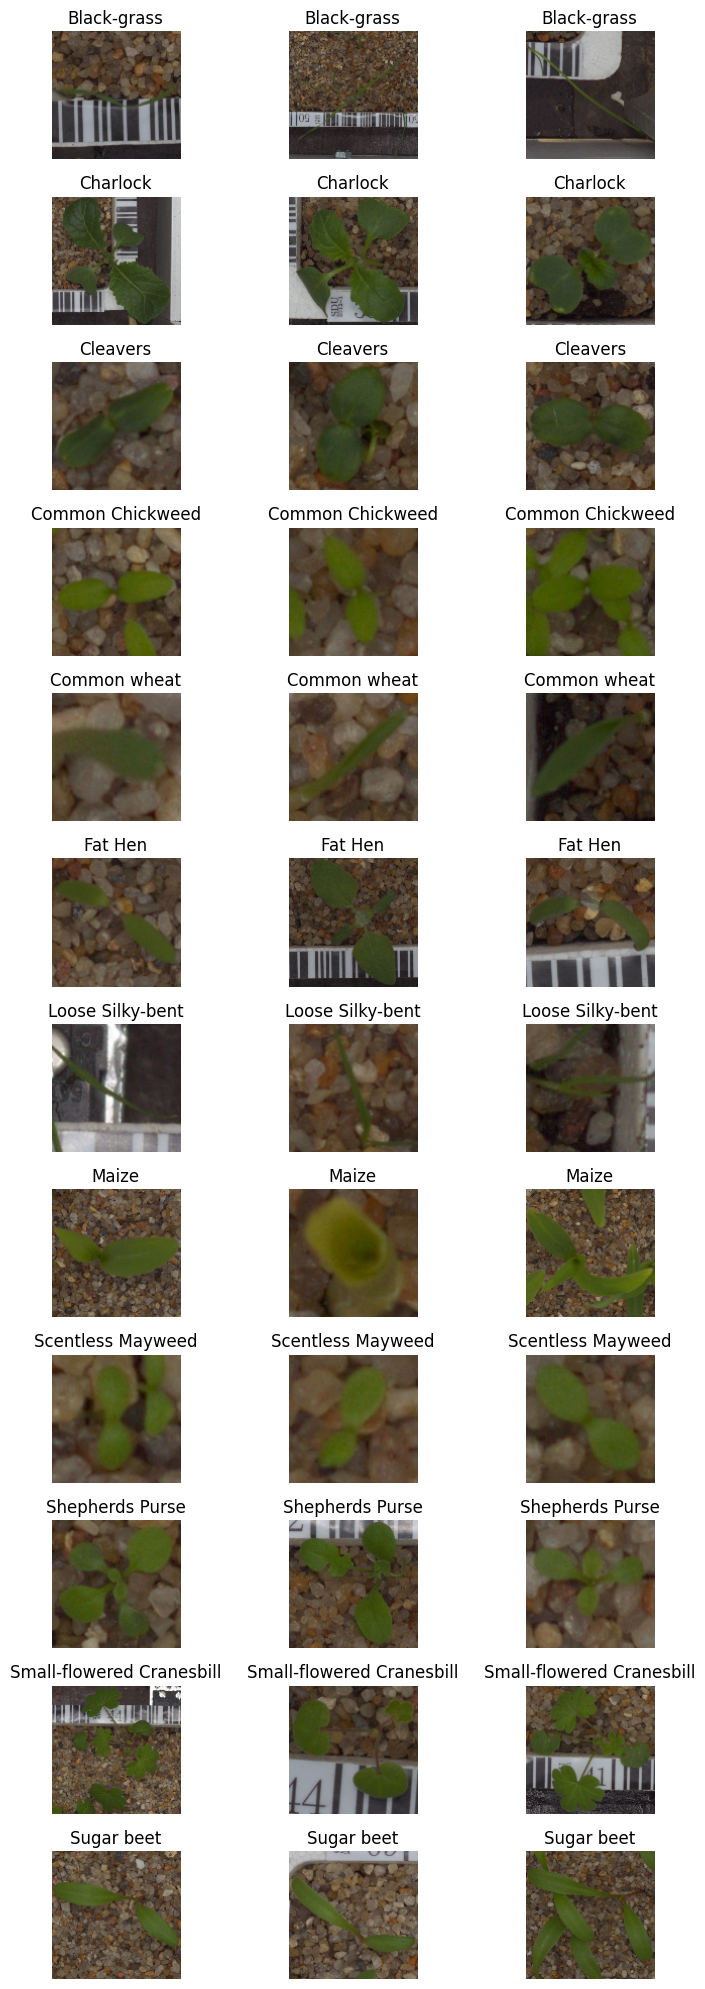

In [16]:
# print random 3 images from each category
plt.figure(figsize=(8,20))
num_images_per_category = 3
for index,cat in enumerate(categories):
  random.seed(random_state)
  rand_choices = random.choices(y[y['Label'] == cat].index, k=num_images_per_category)
  for i, rand_choice in enumerate(rand_choices):
        ax = plt.subplot(
            len(categories),
            num_images_per_category,
            index * num_images_per_category + i + 1)
        img = cv2.cvtColor(X[rand_choice], cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(cat)
        ax.axis('off')
plt.tight_layout()
plt.show()

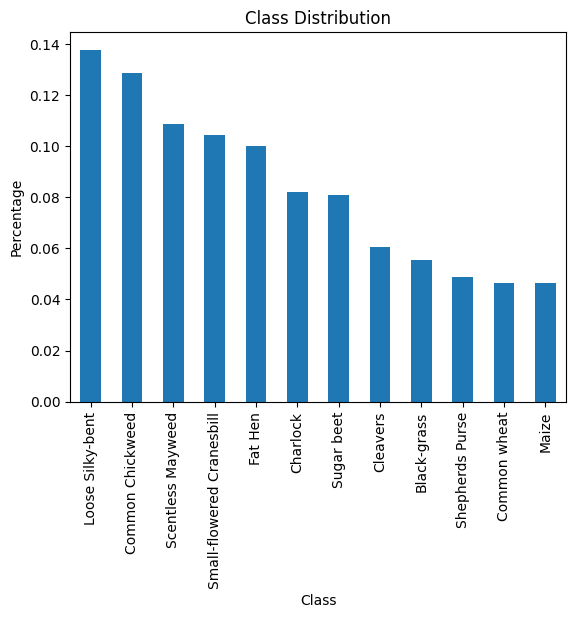

In [17]:
y['Label'].value_counts(normalize=True).plot.bar()
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.show()

### Observations
* We checked the shape of the images and also plotted the images. All images have same size of 128*128 pixel.
* We have 12 categories of images
* We first plotted a random image from each categories and we noticed that seedlings vary from each other in-terms of their leaf shapes and sizes. Their background also varies from each other. Some images contain multiple seedlings of same type.
* We also plotted 3 random images from each categories to understand the visual variance among images of same categories. We observed that leaf shape and sizes vary among images in the same category. The image background, contrast and blurriness also vary among images in the same category.
* We noticed  the dataset is imbalanced. Loose Silky-bent,Common Chickweed, Scentless Mayweed are the top 3 categories. Some categories like Common Wheat and Maize have as little as just over 4% representation in the dataset.


## Data Pre-Processing

### Convert the BGR images to RGB images.

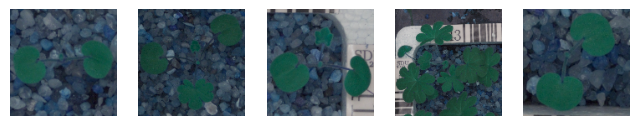

In [18]:
plt.figure(figsize=(8,8))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(X[i])
  plt.axis('off')
plt.show()

In [19]:
X_RGB = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in X])

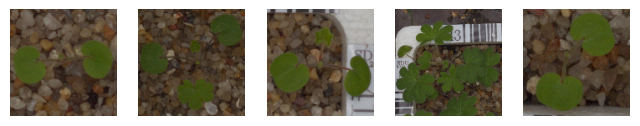

In [20]:
plt.figure(figsize=(8,8))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(X_RGB[i])
  plt.axis('off')
plt.show()

* After converting the images to RGB, matplotlib library can plot the images without the blue taint.

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

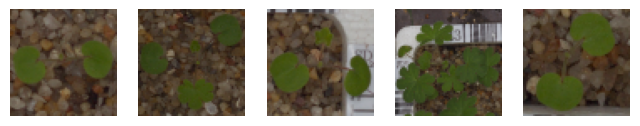

In [21]:
X_resized = np.array([cv2.resize(img, (64, 64)) for img in X_RGB])
# plotting first 5 resized images
plt.figure(figsize=(8,8))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(X_resized[i])
  plt.axis('off')
plt.show()

### Data Preparation for Modeling

- Before we proceed to build a model, we need to split the data into train and test. We will use 10% of train data for validation.
- We will have to encode categorical features and scale the pixel values.
- We will increase class weights for the minority classes
- You will build a model using the train data and then check its performance

In [22]:
# Train, Test split
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.1, random_state = random_state, stratify = y)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4275, 64, 64, 3), (475, 64, 64, 3), (4275, 1), (475, 1))

### Encode the target labels

In [24]:
lb = LabelBinarizer()
y_train_encoded = lb.fit_transform(y_train)
y_test_encoded = lb.transform(y_test)

In [25]:
y_train_encoded.shape, y_test_encoded.shape

((4275, 12), (475, 12))

### Data Normalization

In [26]:
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0

### Class weight

In [27]:
classes = np.unique(y_train)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train['Label'])
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.5031645569620253, 1: 1.014957264957265, 2: 1.380813953488372, 3: 0.6477272727272727, 4: 1.7902010050251256, 5: 0.8343091334894613, 6: 0.6048387096774194, 7: 1.7902010050251256, 8: 0.7677801724137931, 9: 1.7127403846153846, 10: 0.7987668161434978, 11: 1.026657060518732}


## Model Building

* We will build CNN model first with balanced class weights above
* We will use batch normalization and dropout which will help with internal covriate shift and regularization.
* We will tune the model with hyper parameters to improve performance
* We will build a model with data augmentation
* If we are not happy with the performance we might want to try a pre-trained model and fine tune it


### CNN model with `class_weights` and without data augmentation

#### Model architecture building and training

In [ ]:
# Early stopping: Stop early if validation loss doesn't decrease after 5 epoch
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
# Model checkpoint: Save the best model with highest accuracy in validation data, so it can be loaded to continue training from the saved state
mc = ModelCheckpoint('/content/drive/MyDrive/AI_ML_PGP/Projects/PlantSeedlingsClassification/cnn_weighted_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
reset_session()
model = Sequential([
    # Input layer
    Input(shape=(64, 64, 3), name='Input_Layer'),
    # Layer 1
    Conv2D(128, (3, 3), activation=None, padding = 'same', name = 'Conv1_128'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2, 2),
    # Layer 2
    Conv2D(64, (3, 3), activation=None, padding = 'same', name = 'Conv2_64'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2, 2),

    # Layer 3
    Conv2D(32, (3, 3), activation=None, padding = 'same', name = 'Conv3_32'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2, 2),

    # Layer 4
    Conv2D(32, (3, 3), activation=None, padding = 'same', name = 'Conv4_32'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2, 2),

    # FC layer 1
    Flatten(),
    Dense(128, activation='relu', name = 'FC1_128'),
    Dropout(0.25),

    # FC layer 2
    Dense(64, activation='relu', name = 'FC2_64'),
    Dropout(0.25),

    # FC layer 3
    Dense(32, activation='relu', name = 'FC3_32'),
    Dropout(0.25),

    # Output layer
    Dense(12, activation='softmax', name = 'Output_12')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1_128 (Conv2D)                   │ (None, 64, 64, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2_64 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3_32 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4_32 (Conv2D)                    │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1_128 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 182,508 (712.92 KB)

 Trainable params: 181,996 (710.92 KB)

 Non-trainable params: 512 (2.00 KB)

* Our first model has 4 convolution layers and 3 fully connected layers
* It has total 182,508 params and among thsoe 181,996 are trainable

In [ ]:
history = model.fit(X_train_norm, y_train_encoded, batch_size=32, epochs=50, validation_split=0.1, class_weight=class_weight_dict, callbacks=[es, mc])

Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.0806 - loss: 2.6187
Epoch 1: val_accuracy improved from -inf to 0.12383, saving model to /content/drive/MyDrive/AI_ML_PGP/Projects/PlantSeedlingsClassification/cnn_weighted_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.0808 - loss: 2.6178 - val_accuracy: 0.1238 - val_loss: 2.4849
Epoch 2/50
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1713 - loss: 2.3358
Epoch 2: val_accuracy did not improve from 0.12383
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1725 - loss: 2.3308 - val_accuracy: 0.1238 - val_loss: 3.8904
Epoch 3/50
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3208 - loss: 1.8846
Epoch 3: val_accuracy did not improve from 0.12383
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3211 - loss: 1.8830 - val_accuracy: 0.1238 - val_loss: 6.3170
Epoch 4/50
117/121 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4132 - loss: 1.6078
Epoch 4: val_accuracy improved

##### Plotting epochs vs accuracy

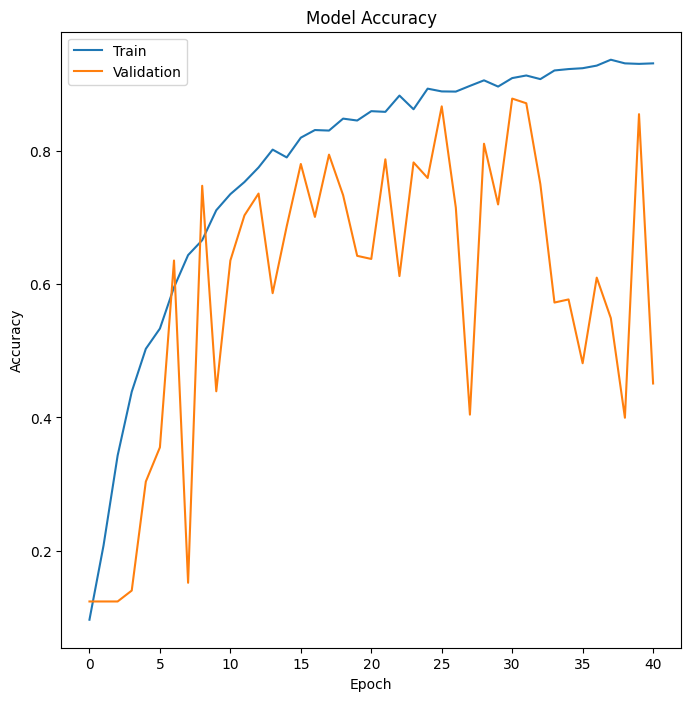

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Loading saved CNN model
This allows us to use the saved model in previous step and save the time and cost for re-training from scratch each time we run the notebook

In [78]:
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/AI_ML_PGP/Projects/PlantSeedlingsClassification/cnn_weighted_model.keras')

#### Model evaluation and performance

In [79]:
# evaluating the model
cnn_model.evaluate(X_test_norm, y_test_encoded)

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 319ms/step - accuracy: 0.8624 - loss: 0.4596


[0.5718783140182495, 0.8378947377204895]

In [80]:
# Test prediction and accuracy
y_pred = cnn_model.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)
accuracy_score(y_test_classes, y_pred_classes)

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step


0.8378947368421052

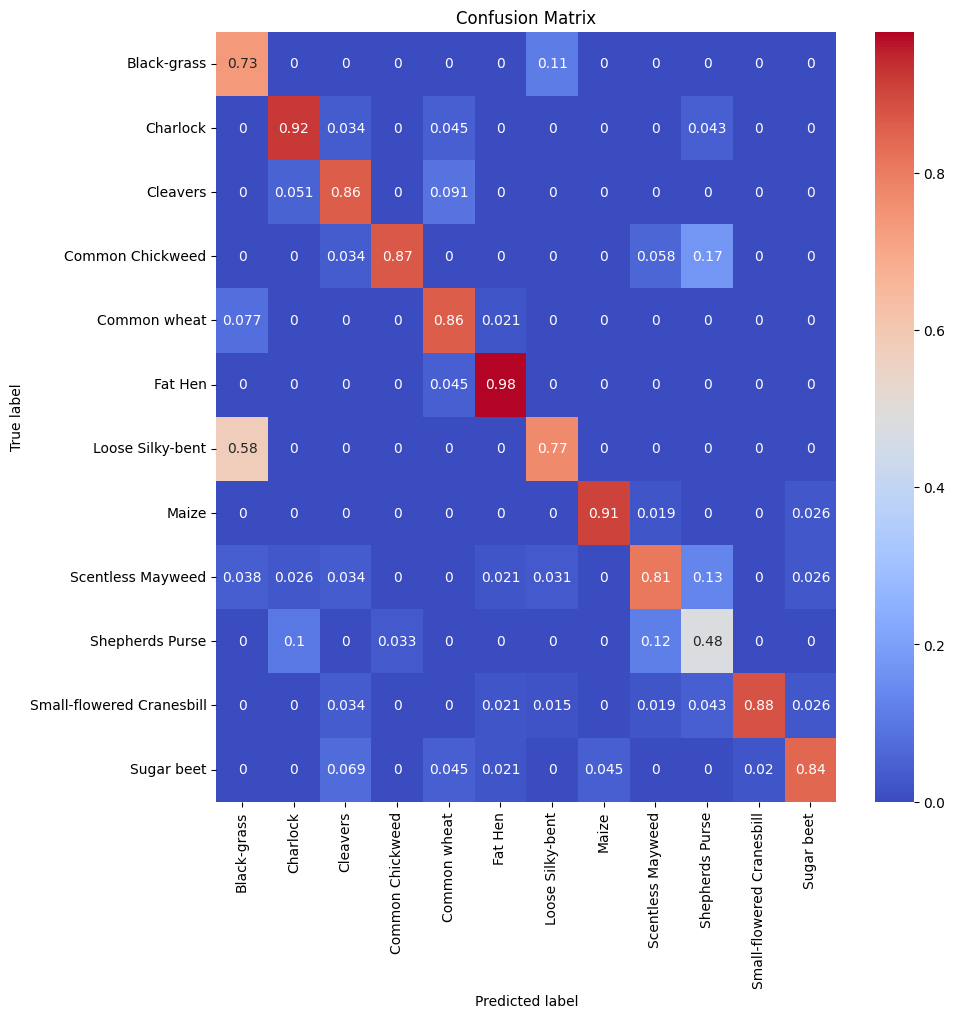

In [81]:
# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
cf_matrix_norm = cm / np.sum(cm, axis=1)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix_norm, annot=True, xticklabels=categories, yticklabels=categories, cmap='coolwarm')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [82]:
class_report = classification_report(y_test_classes, y_pred_classes, target_names=categories)
print(class_report)

                           precision    recall  f1-score   support

              Black-grass       0.51      0.73      0.60        26
                 Charlock       0.84      0.92      0.88        39
                 Cleavers       0.81      0.86      0.83        29
         Common Chickweed       0.96      0.87      0.91        61
             Common wheat       0.79      0.86      0.83        22
                  Fat Hen       0.92      0.98      0.95        48
         Loose Silky-bent       0.83      0.77      0.80        65
                    Maize       0.95      0.91      0.93        22
        Scentless Mayweed       0.79      0.81      0.80        52
          Shepherds Purse       0.55      0.48      0.51        23
Small-flowered Cranesbill       0.98      0.88      0.93        50
               Sugar beet       0.91      0.84      0.88        38

                 accuracy                           0.84       475
                macro avg       0.82      0.83      0.82    

### Observations
* Above we created CNN model and we used class weight to give more importance to the minority classes.
* Our model has 4 convolutional layer and 3 fully connected layer
* It has total 182,508 params and among thsoe 181,996 are trainable
* We stopped training the model if the validation data set loss doesn't decrease after 10 epochs and saved the best model to a file.
* With the above configuration our model stopped training after epoch 41 and restoring model weights from the end of the best epoch: 31.
* The model achieved around 91% training accuracy and 87% validation accuracy at the end of the epoch 31.
* We used this model to evaluate against the test dataset and make prediction. The model achieved 83.7% accuracy against the test data set.
* Though the overall score is promising, the model slightly overfits.
* From confusion matrix we observe that only 48% `Shepherds Purse` are correctly identified  
* From the classification report we observe that the model has overall 84% weighted accurary.
* The recall for `Shepherd Purse` is just 48%, suggesting many `Shephered Purse` samples are wrongly mis-classified.

## Model Performance Improvement



### Performance improvement with ReduceLROnPlateau and SGD
* We will try to improve the performance of the model by reducing the learning rate if accuracy stops improving.
* We will use `ReduceLROnPlateau` along with `EarlyStopping` <br />
&nbsp; &nbsp; &nbsp; &nbsp; **ReduceLROnPlateau:** Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. [Here is the documentation](https://keras.io/api/callbacks/reduce_lr_on_plateau/)
* We used `adam` optimizer in the previous step, however, `ReduceLROnPlateau` is more effective when we use SGD. SGD uses global learning rate. When learning rate reduces it impacts the step size.
* We will use same architecture that we used in previous step

#### Model training

In [ ]:
# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, patience=5, min_lr=1e-6)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('/content/drive/MyDrive/AI_ML_PGP/Projects/PlantSeedlingsClassification/cnn_model_sgd.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
# Loading the previous model (saved CNN model) architecture, reset the weight and train it with reduce_lr
reset_session()
# Clone the saved cnn_model
model = clone_model(cnn_model)
# Build a new model by resetting the weight of the cnn model with the same input shape
model.build(cnn_model.input_shape)
#optimizer
optimizer = SGD(learning_rate=0.01, momentum=0.9)
# compile
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_norm, y_train_encoded, batch_size=32, epochs=50, validation_split=0.1, class_weight=class_weight_dict, callbacks=[es, mc, reduce_lr])

Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0858 - loss: 2.5916
Epoch 1: val_accuracy improved from -inf to 0.12617, saving model to /content/drive/MyDrive/AI_ML_PGP/Projects/PlantSeedlingsClassification/cnn_model_sgd.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.0858 - loss: 2.5909 - val_accuracy: 0.1262 - val_loss: 2.4765 - learning_rate: 0.0100
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1025 - loss: 2.4728
Epoch 2: val_accuracy improved from 0.12617 to 0.14953, saving model to /content/drive/MyDrive/AI_ML_PGP/Projects/PlantSeedlingsClassification/cnn_model_sgd.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.1027 - loss: 2.4722 - val_accuracy: 0.1495 - val_loss: 2.3697 - learning_rate: 0.0100
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1800 - loss: 2.1614
Epoch 3: val_accuracy improved from 0.14953 to 0.35748, saving model to /content/drive/MyDrive/AI_ML_PGP/Projects/PlantSeedlingsClassifica

##### Plotting epochs vs accuracy

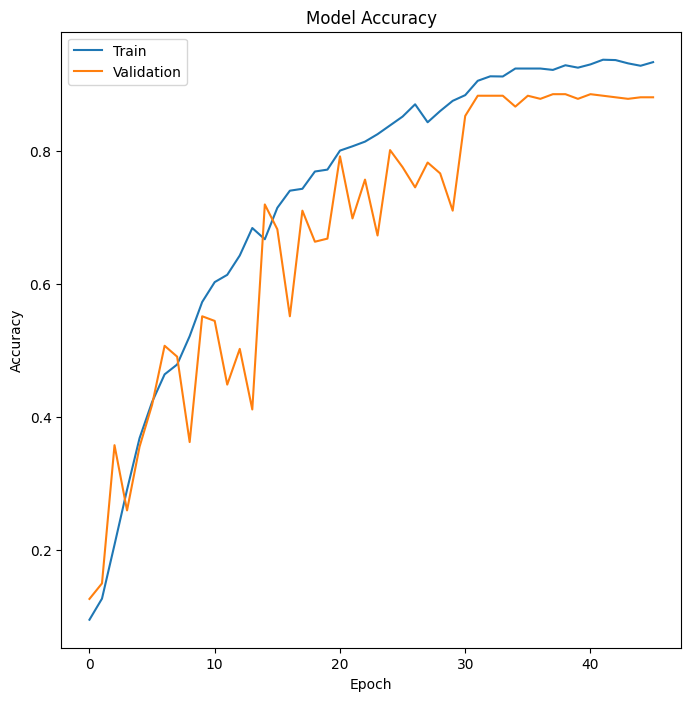

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Loading the saved model

In [83]:
cnn_model_sgd = tf.keras.models.load_model('/content/drive/MyDrive/AI_ML_PGP/Projects/PlantSeedlingsClassification/cnn_model_sgd.keras')

#### Model evaluation and performance

In [84]:
# Model evaluation
cnn_model_sgd.evaluate(X_test_norm, y_test_encoded)

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.9169 - loss: 0.3877


[0.5075504183769226, 0.8926315903663635]

In [85]:
# Test prediction and accuracy
y_pred = cnn_model_sgd.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)
accuracy_score(y_test_classes, y_pred_classes)

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step


0.8926315789473684

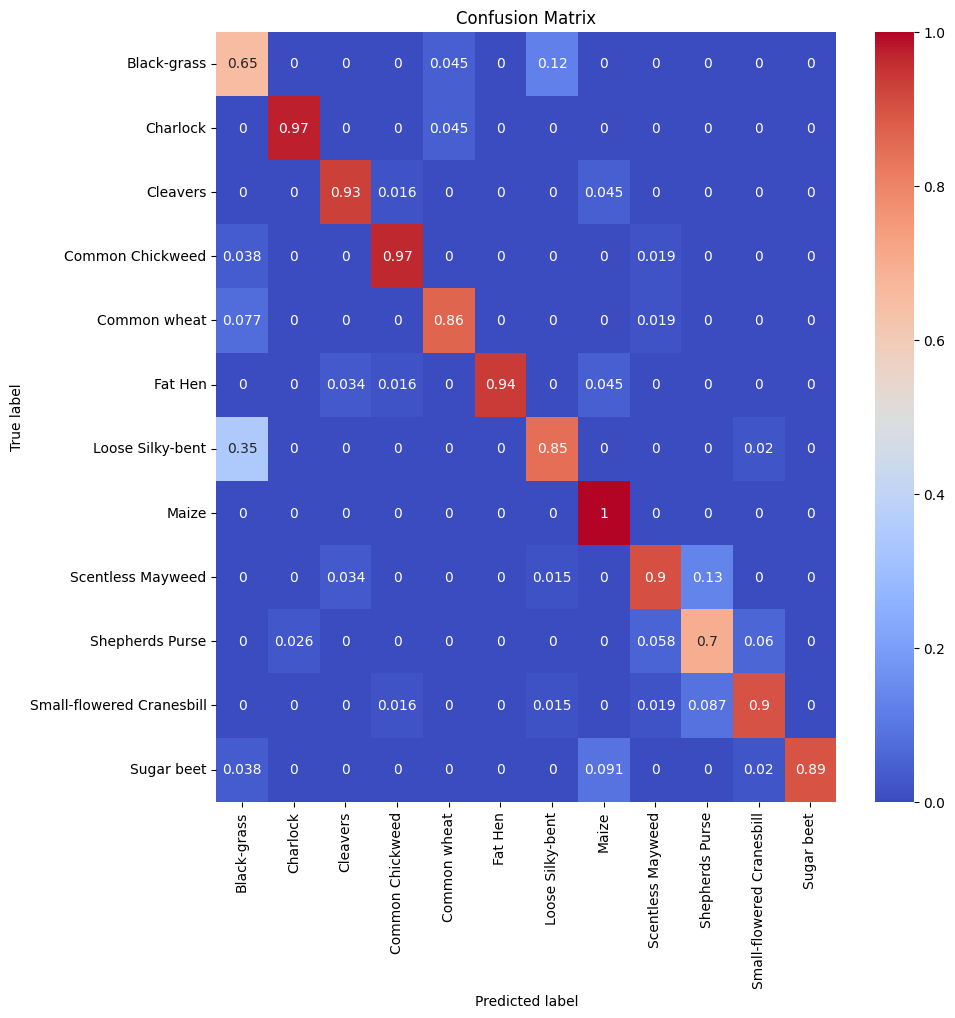

In [86]:
# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
cf_matrix_norm = cm / np.sum(cm, axis=1)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix_norm, annot=True, xticklabels=categories, yticklabels=categories, cmap='coolwarm')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [87]:
# Classification report
class_report = classification_report(y_test_classes, y_pred_classes, target_names=categories)
print(class_report)

                           precision    recall  f1-score   support

              Black-grass       0.57      0.65      0.61        26
                 Charlock       0.97      0.97      0.97        39
                 Cleavers       0.93      0.93      0.93        29
         Common Chickweed       0.95      0.97      0.96        61
             Common wheat       0.90      0.86      0.88        22
                  Fat Hen       1.00      0.94      0.97        48
         Loose Silky-bent       0.85      0.85      0.85        65
                    Maize       0.85      1.00      0.92        22
        Scentless Mayweed       0.89      0.90      0.90        52
          Shepherds Purse       0.76      0.70      0.73        23
Small-flowered Cranesbill       0.90      0.90      0.90        50
               Sugar beet       1.00      0.89      0.94        38

                 accuracy                           0.89       475
                macro avg       0.88      0.88      0.88    

### Observations
* We observe that after tuning with `SGD` optimizer and `ReduceLROnPlateau` the model performance improved both in the training and validation set.
* The best model has around 92% accuracy in training dataset and around 88% accuracy in the validation dataset.
* The model is performing well in the test dataset with around 89% accuracy. Model is generalizing well.
* From the confusion matrix and classification report we observe that the recall for `Black-Grass` is reduced to 65% from 73%, but, the recall for `Shepherds Purse` improved from 48% to 70%.
* The weigted average accuracy is 89%

### Data Augmentation

* Previous models only used class weights to balance the dataset. It gave higher importance to under-represented classes but didn't add any synthetic data.
* We can combine data augmentation with class weight. Data Augementation will add synthetic data and class wieght will add more importance to the under-represented classes.

#### Augmenation configuration

In [88]:
reset_session()

In [89]:
# Define data augmentation settings
# We will reuse the normalized dataset, so we are not going to rescale the images
aug_settings = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = False,
    rotation_range = 20,
    shear_range = 0.1,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
)

We have to split the train dataset for validation as we can't use `validation_split` inside the `fit()`. We are going to fit the model with `train_generator` and `val_generator` instead of `X_train_norm` and `y_train_encoded` arrays.

In [90]:
# Split data into training and validation sets
X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(
    X_train_norm,
    y_train_encoded,
    test_size=0.1,  # 10% for validation
    random_state = random_state,
    stratify = y_train_encoded
)

# Creates train augmented generator
train_generator = aug_settings.flow(
    X_train_aug,
    y_train_aug,
    batch_size=32,
    shuffle=True)
val_generator = aug_settings.flow(
    X_val_aug,
    y_val_aug,
    batch_size=32,
    shuffle=False)

#### Model Training

In [91]:
# ReduceLROnPlateau, EarlyStopping and ModelCheckpoint
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, patience=5, min_lr=1e-6)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('/content/drive/MyDrive/AI_ML_PGP/Projects/PlantSeedlingsClassification/cnn_model_sgd_aug.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [92]:
# Clone the saved cnn_model_sgd
model = clone_model(cnn_model_sgd)
# Build a new model by resetting the weight of the cnn_model_sgd with the same input shape
model.build(cnn_model_sgd.input_shape)
#optimizer
optimizer = SGD(learning_rate=0.01, momentum=0.9)
# compile
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [93]:
history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=len(X_train_aug)//32,
    validation_data = val_generator,
    validation_steps = len(X_val_aug)//32,
    class_weight=class_weight_dict,
    callbacks=[es, mc, reduce_lr]
)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0957 - loss: 2.5824
Epoch 1: val_accuracy improved from -inf to 0.10337, saving model to /content/drive/MyDrive/AI_ML_PGP/Projects/PlantSeedlingsClassification/cnn_model_sgd_aug.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.0958 - loss: 2.5818 - val_accuracy: 0.1034 - val_loss: 2.4805 - learning_rate: 0.0100
Epoch 2/50
  1/120 ━━━━━━━━━━━━━━━━━━━━ 2:09 1s/step - accuracy: 0.1250 - loss: 2.2314
Epoch 2: val_accuracy improved from 0.10337 to 0.16667, saving model to /content/drive/MyDrive/AI_ML_PGP/Projects/PlantSeedlingsClassification/cnn_model_sgd_aug.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.1250 - loss: 2.2314 - val_accuracy: 0.1667 - val_loss: 2.4530 - learning_rate: 0.0100
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1043 - loss: 2.4698
Epoch 3: val_accuracy did not improve from 0.16667
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.1044 - loss: 2.4695 -

##### Plotting epochs vs accuracy

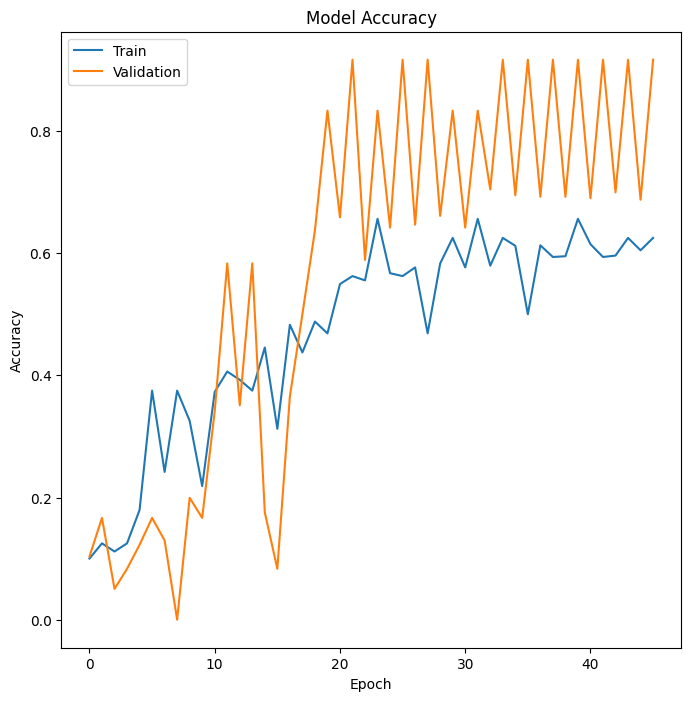

In [96]:
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

#### Loading the saved model

In [97]:
cnn_model_aug = tf.keras.models.load_model('/content/drive/MyDrive/AI_ML_PGP/Projects/PlantSeedlingsClassification/cnn_model_sgd_aug.keras')

#### Model evaluation and performance

In [101]:
# model evaluation
cnn_model_aug.evaluate(X_test_norm, y_test_encoded)

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 256ms/step - accuracy: 0.6759 - loss: 1.0138


[1.0811728239059448, 0.6294736862182617]

In [102]:
# prediction
y_pred = cnn_model_aug.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)
accuracy_score(y_test_classes, y_pred_classes)

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step


0.6294736842105263

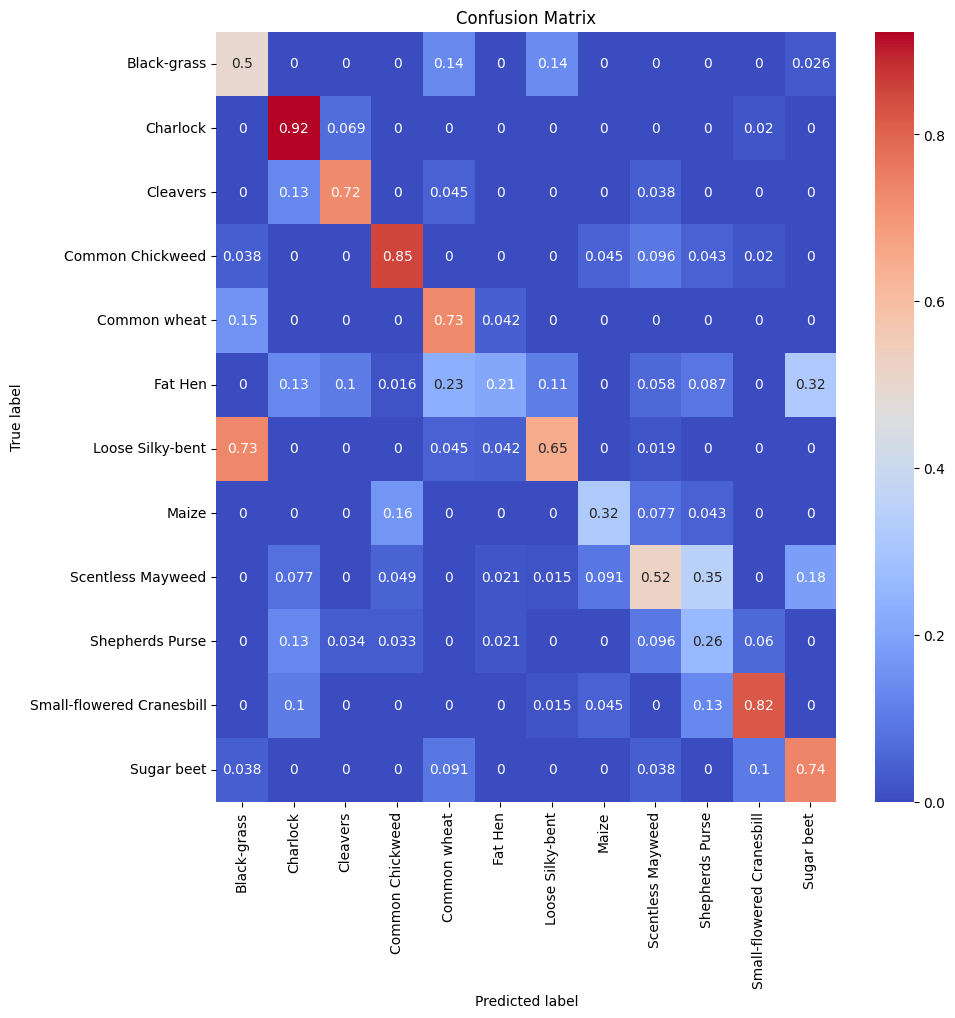

In [103]:
# confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
cf_matrix_norm = cm / np.sum(cm, axis=1)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix_norm, annot=True, xticklabels=categories, yticklabels=categories, cmap='coolwarm')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [104]:
# classification report
class_report = classification_report(y_test_classes, y_pred_classes, target_names=categories)
print(class_report)

                           precision    recall  f1-score   support

              Black-grass       0.34      0.50      0.41        26
                 Charlock       0.62      0.92      0.74        39
                 Cleavers       0.78      0.72      0.75        29
         Common Chickweed       0.76      0.85      0.81        61
             Common wheat       0.57      0.73      0.64        22
                  Fat Hen       0.62      0.21      0.31        48
         Loose Silky-bent       0.70      0.65      0.67        65
                    Maize       0.64      0.32      0.42        22
        Scentless Mayweed       0.55      0.52      0.53        52
          Shepherds Purse       0.29      0.26      0.27        23
Small-flowered Cranesbill       0.80      0.82      0.81        50
               Sugar beet       0.58      0.74      0.65        38

                 accuracy                           0.63       475
                macro avg       0.61      0.60      0.59    

### Observations
* Above we tried data augmentation with class weights. We didn't achieve a good performance. We noticed that the model achieved around 56% train accuracy and 91% valdation accuracy. This suggests underfitting during training.
* The model achieved around 62% accuracy in the test dataset, generalizing better than the validation dataset.
* The above suggests one or both of the following: <br />
    * The validation data is too small
    * There are overlapping similarities or data leakage between validation and training dataset
    * The validation data is biased
* We could have built another model by changing the data split, however, we achieved good success without data augementation. So we are going to choose our final model from the first two models we built.

## Final Model
* We built 3 models. All 3 models have same architecture with 4 convolutional layers and 3 fully connected layers. All these models have 181,996 trainable parameters.
* **Model 1**: We used `class_weights` to give higher importance to the minority classes. We used `adam` optimizer. This model achieved around 91% accuracy in the training data, 87% accuracy in the validation dataset and around 84% accuracy in the test dataset. Though the model performs well, it indicates slight overfitting.
* **Model 2**: We used `sgd` optimizer with `ReducedLrOnPlateaue` to achive better performance. We observed 92% accuracy in the training dataset, around 88% accuracy in the validation datset and around 89% accuracy in the test dataset. We can conclude this model performed well in all 3 dataset and it is generalizing well.
* **Model 3**: We used dynamic data augmentation along with class weights. We kept the optimizer and the architecture same as the previoud model. We observed only 56% accuracy in the train dataset, 91% accuracy in the validation dataset and 62% accuracy in test dataset. This suggests underfitting during training and probably an issue with the validation data-split.

* **Final Model**: Model 2 is our final chosen model as it has very good performance and it is generalizing well.

### Loading the final model and making a random prediction

In [28]:
final_model = tf.keras.models.load_model('/content/drive/MyDrive/AI_ML_PGP/Projects/PlantSeedlingsClassification/cnn_model_sgd.keras')

In [30]:
y_pred = final_model.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)
accuracy_score(y_test_classes, y_pred_classes)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


0.8926315789473684

In [33]:
# get a random image index
random_index = np.random.randint(0, len(X_test_norm))
random_index

348

In [34]:
# prediction
result = final_model.predict(np.expand_dims(X_test_norm[random_index], axis=0))
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


array([[3.9270812e-01, 1.7879278e-05, 4.5150420e-05, 1.0130113e-04,
        1.2365825e-03, 4.7762040e-03, 6.0056323e-01, 4.8438801e-06,
        4.6698211e-04, 7.8904714e-06, 4.9278548e-05, 2.2528231e-05]],
      dtype=float32)

In [39]:
i = np.argmax(result)
y_test_classes[random_index], categories[i]

(6, 'Loose Silky-bent')

### Visualizing the prediction

In [55]:
actual = y_test.iloc[random_index]['Label']

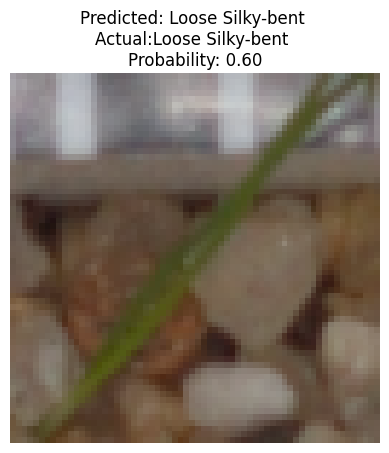

In [59]:
plt.imshow(X_test[random_index])
plt.title(f'Predicted: {categories[i]} \nActual:{actual} \nProbability: {result[0][i]:.2f}')
plt.axis('off')
plt.show()

## Actionable Insights and Business Recommendations

* Our final model gives us 89% accuracy in the test dataset.
* We noticed the recall for `Black-grass` and `Shepherds Purse` are low, 65% and 70% respectively.
* The above could be due to smaller dataset and image quality.
* We noticed the model is wrongly predicting `Loosly Silky-bent` as `Black-grass`.
* Increasing the sample size of `Black-grass` and improving the image quality would help to improve the recall score.
* The same is applicable for `Shepherds Purse` as the sample size for it is also small. We noticed `Scentless Mayweed` and `Small-flowered Cranesbill` are wrongly predicted as `Shepherds Purse`
* Here, we didn't fine tune a pre-trained model like `VGG-16`, `RestNet` or `EfficientNet`. If the recommended model doesn't perform well against the real world data, we recommend fine-tuning a pre-trained model that has good performance for this kind of dataset.

_____